In [1]:
using PyPlot, LinearAlgebra

# Large-scale linear algebra: Dense matrix methods

The basic problem with most of the linear algebra techniques we have learned so far is that they **scale badly for large matrices**.   Ordinary Gaussian elimination (LU factorization), Gram–Schmidt and other QR factorization algorithms, and techniques that computes *all* the eigenvalues and eigenvectors, all require $\sim n^3$ operations and $\sim n^2$ storage for $n \times n$ matrices.

This all assumes that you explicitly store and compute with all of the entries of the matrix, regardless of their values.  Hence, they are sometimes called **dense matrix** algorithms (the opposite of "sparse" matrices, discussed below).

So, doubling the size of the matrix *asymptotically* requires about 8× more time.  For any *finite* $n$, it is not quite a factor of 8 because *computers are complicated*; e.g. for larger matrices, it can use multiple processors more efficiently:

In [2]:
A1 = randn(500,500)
A2 = randn(1000,1000)
lu(A1); # do it once to make sure it is compiled
@elapsed(lu(A2)) / @elapsed(lu(A1))

4.565522673701417

In [3]:
qr(A1); # do it once to make sure it is compiled
@elapsed(qr(A2)) / @elapsed(qr(A1))

5.037932201089998

In [4]:
eigen(A1); # do it once to make sure it is compiled
@elapsed(eigen(A2)) / @elapsed(eigen(A1))

3.836594448891638

In [5]:
@time lu(A2)
@time eigen(A2);

  0.040024 seconds (4 allocations: 7.637 MiB, 35.35% gc time)
  1.189946 seconds (21 allocations: 31.580 MiB)


Still, if we take the $O(n^3)$ scaling as a rough guide, this would suggest that LU-factorizing (`lufact`) a $10^6 \times 10^6$ matrix would take $0.01\mbox{sec} \times 1000^3 \sim \mbox{months}$ and finding the eigenvectors and eigenvalues (`eigfact`) would take $1 \mbox{sec} \times 1000^3 \sim \mbox{decades}$.

In practice, we actually usually **run out of space before we run out of time**.   If we have 16GB of memory, the biggest matrix we can *store* (each number requires 8 bytes) is $8n^2\mbox{ bytes} = 16\times 10^9 \implies 40000 \times 40000$.

# Sparse Matrices

The saving grace is that most *really* large matrices are **sparse = mostly zeros** (or have some other special structure with similar consequences).  You only have to **store the nonzero entries**, and you can **multiply matrix × vector quickly** (you can skip the zeros).

In Julia, there are many functions to work with sparse matrices by only storing the nonzero elements.  The simplest one is the `sparse` function.  Given a matrix $A$, the `sparse(A)` function creates a special data structure that only stores the nonzero elements:

In [6]:
A = [  2 -1  0  0  0  0
      -1  2 -1  0  0  0
       0 -1  2 -1  0  0
       0  0 -1  2 -1  0
       0  0  0 -1  2 -1
       0  0  0  0 -1  2]

6×6 Matrix{Int64}:
  2  -1   0   0   0   0
 -1   2  -1   0   0   0
  0  -1   2  -1   0   0
  0   0  -1   2  -1   0
  0   0   0  -1   2  -1
  0   0   0   0  -1   2

In [7]:
using SparseArrays

sparse(A)

6×6 SparseMatrixCSC{Int64, Int64} with 16 stored entries:
  2  -1   ⋅   ⋅   ⋅   ⋅
 -1   2  -1   ⋅   ⋅   ⋅
  ⋅  -1   2  -1   ⋅   ⋅
  ⋅   ⋅  -1   2  -1   ⋅
  ⋅   ⋅   ⋅  -1   2  -1
  ⋅   ⋅   ⋅   ⋅  -1   2

(Of course, in practice you would want to create the sparse matrix directly, rather than first making the "dense" matrix `A` and then converting it to a sparse data structure.)

For example, in **graph/network-based problems**, we often get matrices of the form:

$$A = G^T D G$$

where D is diagonal (very sparse!) and G is the incidence matrix.   Since each graph node is typically only connected to a few other nodes, **G is sparse** and so is A.

If each node is connected to a bounded number of other nodes (say, ≤ 20), then A only has $\sim n$ (i.e. *proportional to n, not equal to n*) entries, and $Ax$ can be computed in $\sim n$ operations and $\sim n$ storage (unlike $\sim n^2$ for a general matrix).

So, a $10^6 \times 10^6$ sparse matrix might be stored in only a few megabytes and take only a few milliseconds to multiply by a vector.

Much of large-scale linear algebra is about devising techniques to exploit sparsity or **any case where matrix × vector is faster than n²**.

# Scalable computation of eigenvalues

In fact, we already learned one algorithm that works well for sparse matrices: the [power method](Power-Method.ipynb) to compute eigenvalues and eigenvectors.   If we just repeatedly multiply a random vector by $A$, it converges towards the eigenvector of the largest $|\lambda|$.  And since this only involves matrix × vector operations, it can take advantage of sparse matrices.

Moreover, there are variants of this algorithm that work for the smallest eigenvalues as well, and it turns out that there are more sophisticated variants that converge even faster than power iterations.   In Julia, these are provided by the `eigs` function, which lets you compute a **few** of the biggest or smallest eigenvalues quickly even for huge sparse matrices.

## Example

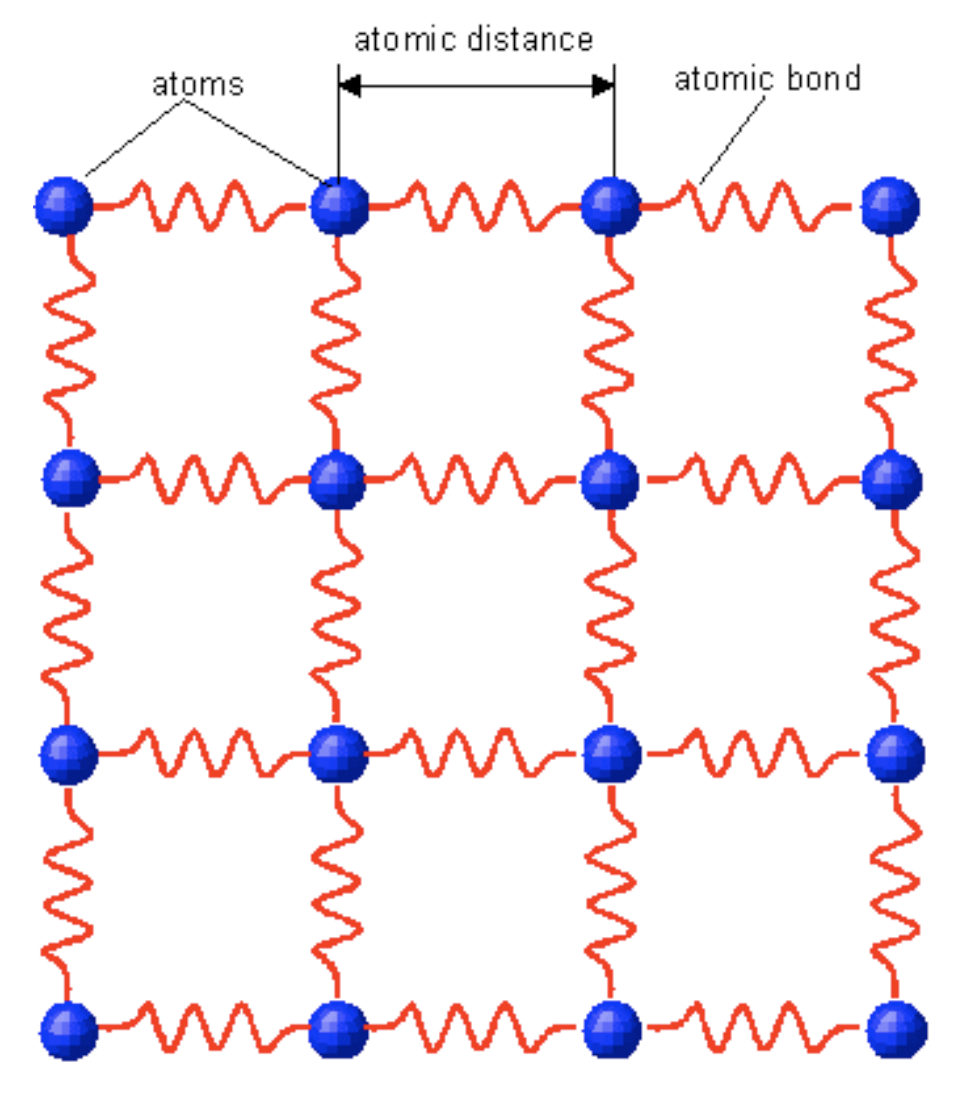

As an example, let's consider the **two-dimensional grid of masses and springs** analogous to the mass-and-spring system analyzed in an earlier lecture, whose eigenvectors are the **vibrating modes**.

This can be thought of as a discretized approximation of a **vibrating drum**, which is described by the partial differential equation $\nabla^2 h = \frac{\partial^2 h}{\partial t^2}$ where $h(x,y,t)$ is the height of the drum surface (= zero at the edges of the drum). (This is an example taken from the class [18.303: Linear Partial Differential Equations](http://math.mit.edu/~stevenj/18.303/) at MIT.)  It can also be thought of as a model for vibrations ("phonon modes") in crystalline atomic solids.

For 18.06, don't worry too much about how the matrix is constructed.

In [8]:
# compute the first-derivative finite-difference matrix
# for Dirichlet boundaries, given a grid x[:] of x points
# (including the endpoints where the function = 0!).
function sdiff1(x)
    N = length(x) - 2
    dx1 = [1/(x[i+1] - x[i]) for i = 1:N]
    dx2 = [-1/(x[i+1] - x[i]) for i = 2:N+1]
    spdiagm(N+1, N, 0=>dx1, -1=>dx2)
end

# compute the -∇⋅ c ∇ operator for a function c(x,y)
# and arrays x[:] and y[:] of the x and y points,
# including the endpoints where functions are zero
# (i.e. Dirichlet boundary conditions).
function Laplacian(x, y, c = (x,y) -> 1.0)
    Dx = sdiff1(x)
    Nx = size(Dx,2)
    Dy = sdiff1(y)
    Ny = size(Dy,2)
    
    # discrete Gradient operator:
    G = [kron(sparse(I,Ny,Ny), Dx); kron(Dy, sparse(I,Nx,Nx))]
    
    # grids for derivatives in x and y directions
    x′ = [0.5*(x[i]+x[i+1]) for i = 1:length(x)-1]
    y′ = [0.5*(y[i]+y[i+1]) for i = 1:length(y)-1]
    
    # evaluate c(x)
    C = spdiagm([ vec([c(X,Y) for X in x′, Y in y[2:end-1]]);
                  vec([c(X,Y) for X in x[2:end-1], Y in y′]) ])
    
    return G' * C * G # -∇⋅ c ∇
end

Laplacian (generic function with 2 methods)

The above code defines the matrix for a box-shaped drum, but for fun I will change it to define a drum over an oddly shaped domain:

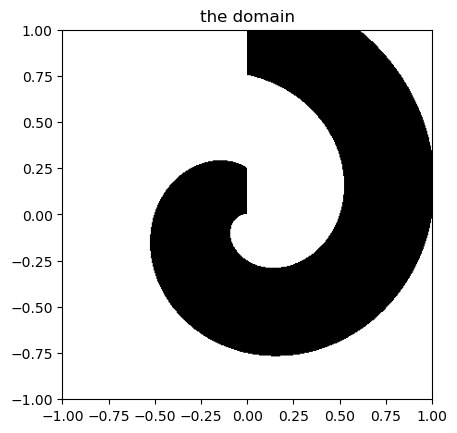

PyObject Text(0.5, 1.0, 'the domain')

In [9]:
N = 400
x = range(-1,1,length=N+2)[2:end-1]
y = x'  # a row vector
r = hypot.(x,y)  # use broadcasting (.+) to make Nx x Ny matrix of radii
θ = atan.(y, x) # and angles
φ = @. exp(-(r - θ*0.5/π - 0.5)^2 / 0.3^2) - 0.5
imshow(φ .> 0, extent=[-1,1,-1,1], cmap="binary")
title("the domain")

This all eventually leads to the following matrix, whose eigenvalues $
\lambda = \omega^2$ are the squares of the frequencies and whose eigenvectors are the vibrating modes:

In [10]:
x0 = range(-1,1,length=N+2) # includes boundary points, unlike x
Abox = Laplacian(x0, x0, (x,y) -> 1.0);
i = findall(>(0), vec(φ))
A = Abox[i,i]
size(A)

(59779, 59779)

This is a $60000\times60000$ matrix, which would too big to even store on my laptop if we stored every entry.  Because it is sparse, however, almost all of the entries are zero and we only need to store those.

The `nnz` function computes the number of nonzero entries, and we can use it to compute the fraction of nonzero entries in A:

In [11]:
nnz(A) / length(A)

8.313882809376213e-5

In [12]:
nnz(A) / size(A,1)

4.969956004617006

Less than 0.01% of the entries are nonzero!  It really pays to take advantage of this.

Now we'll compute a few of the smallest-|λ| eigenvectors using `eigs` from [Arpack.jl](https://github.com/JuliaLinearAlgebra/Arpack.jl).

  4.245233 seconds (6.93 M allocations: 596.607 MiB, 4.13% gc time, 68.60% compilation time)


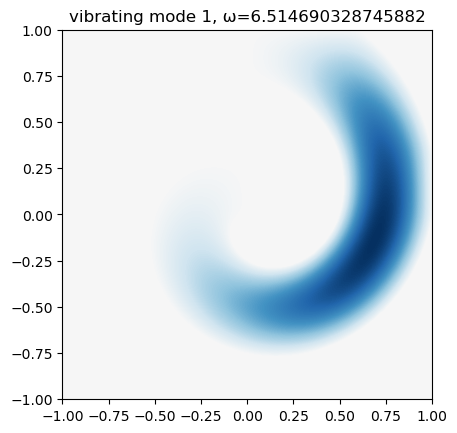

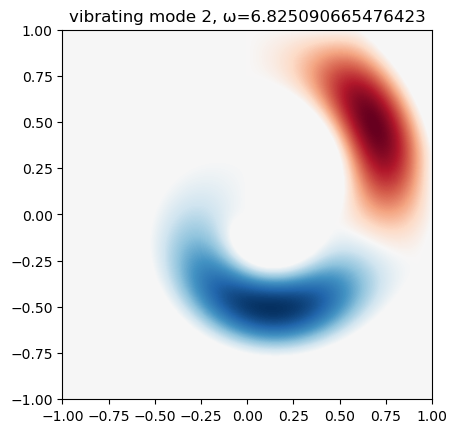

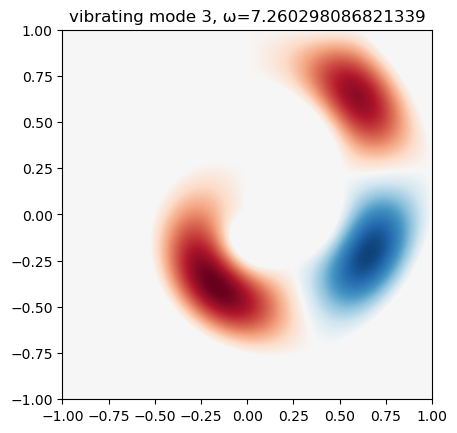

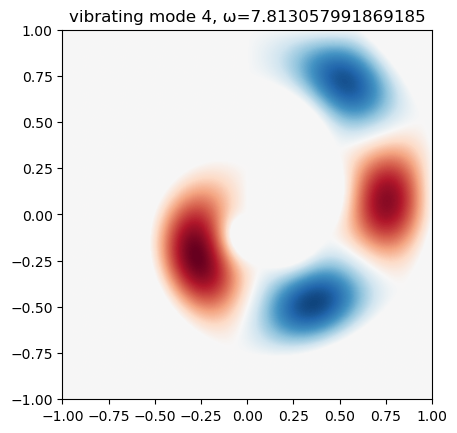

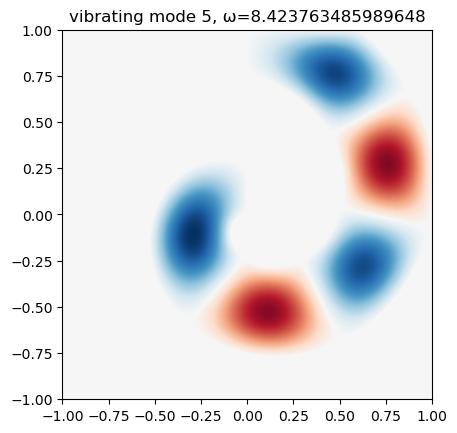

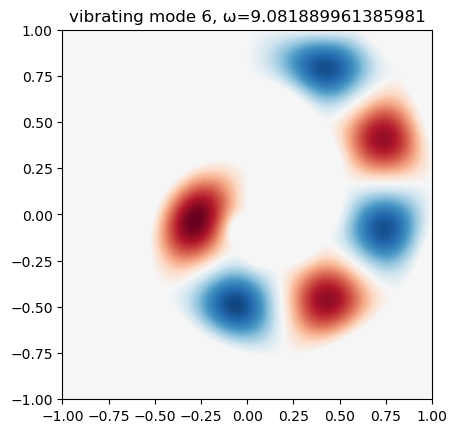

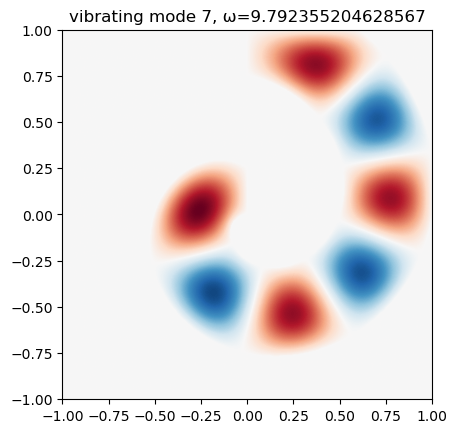

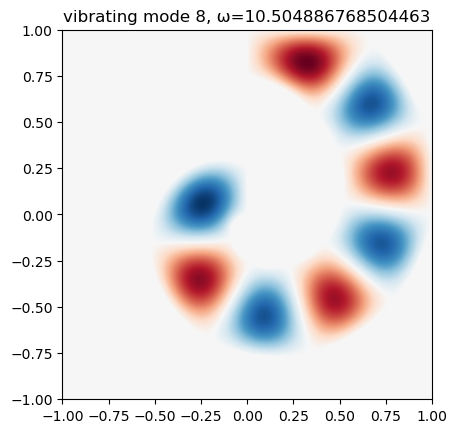

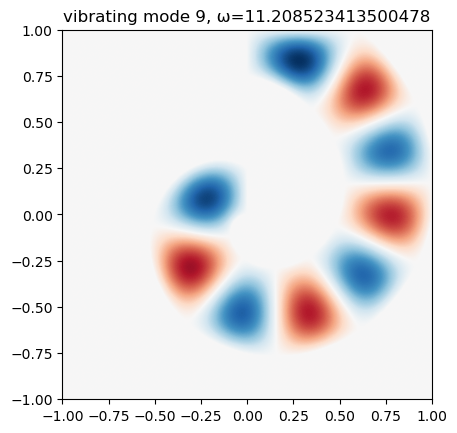

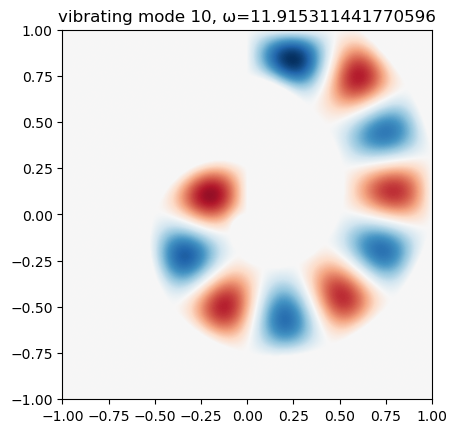

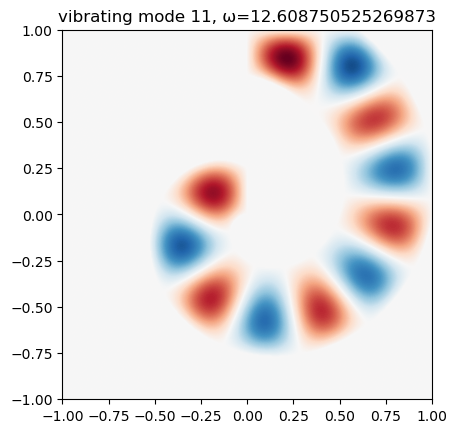

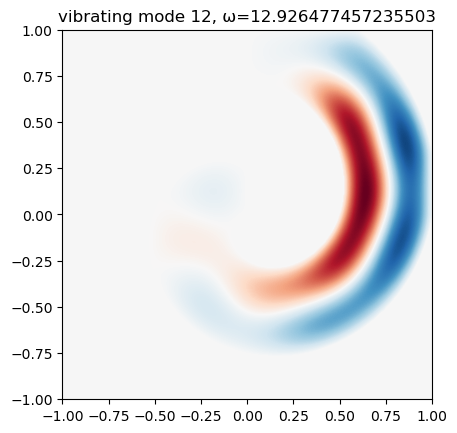

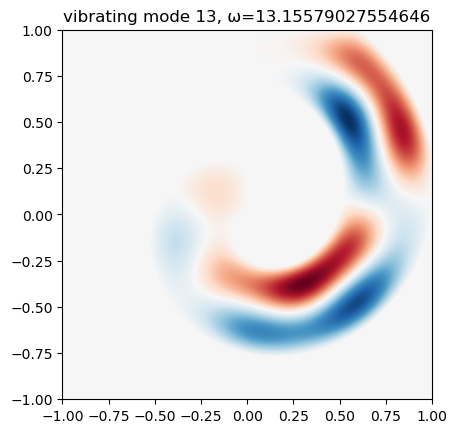

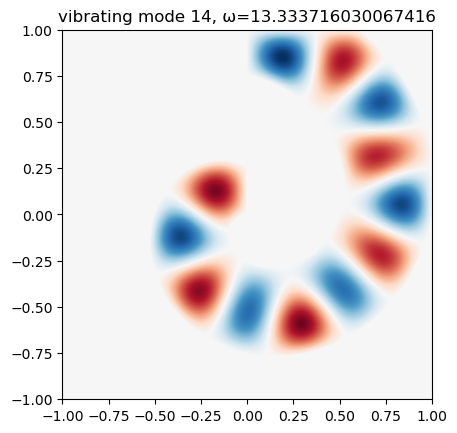

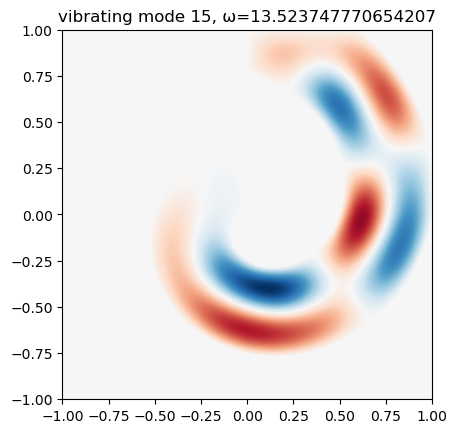

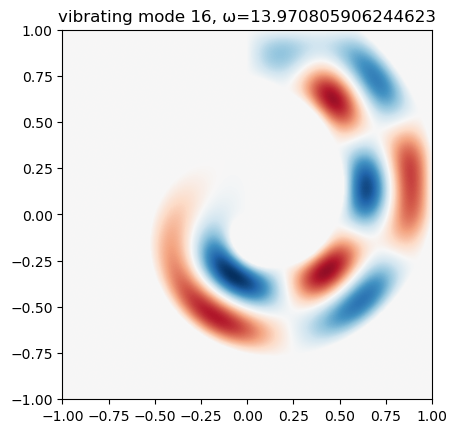

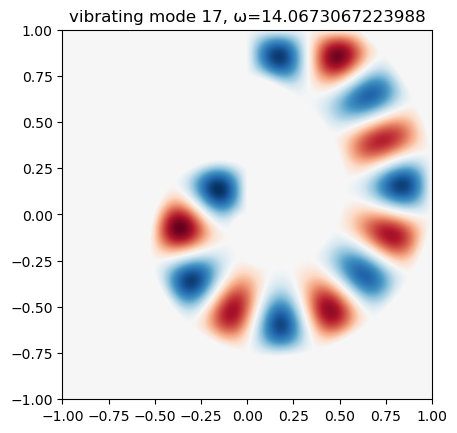

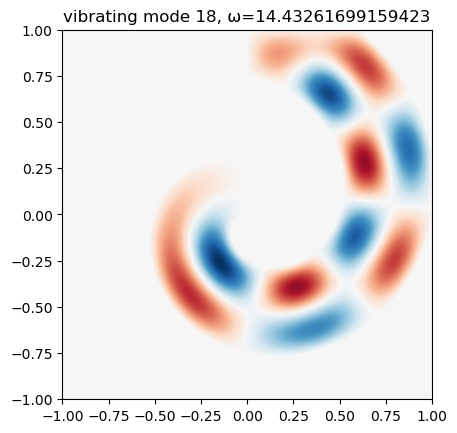

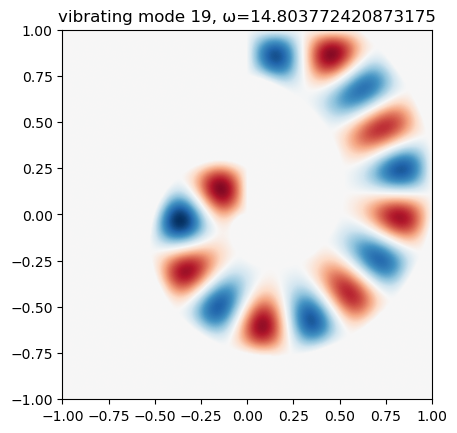

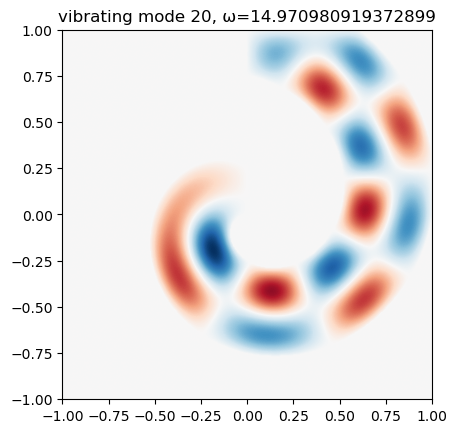

In [13]:
u = zeros(N,N)
using Arpack
@time λ, X = eigs(A, nev=20, which=:SM);

f = figure()
for which_eig in 1:20
    display(
    withfig(f) do
        u[i] = X[:,which_eig]
        umax = maximum(abs, u)
        title("vibrating mode $which_eig, ω=$(sqrt(λ[which_eig]))")
        imshow(u, extent=[-1,1,-1,1], vmin=-umax,vmax=+umax, cmap="RdBu")
    end
    )
end

Notice that it took **only seconds** to solve for 20 eigenvectors and eigenvalues!

This is because `eigs` is essentially using an algorithm like the power method, that only uses repeated multiplication by $A$.

Or, sometimes, particularly to find the smallest $|\lambda|$ eigenvectors, it might repeatedly *divide* by $A$, i.e. solve $Ax=b$ for $b = A^{-1} x$.   But it can't actually compute the inverse matrix, and I said that LU factorization was $\sim n^3$ in general.  So, what is happening?

# Sparse-direct solvers for Ax=b

Even if $A$ is a sparse matrix, $A^{-1}$ is generally *not* sparse.  However, if you arrange things cleverly, often the $L$ and $U$ factors *are* still sparse!

This leads to something called **sparse-direct solvers**: they solve $Ax=b$ by ordinary Gaussian elimination to find $A = LU$, *but* they take advantage of sparse $A$ to avoid computing with zeros. Moreover, they first re-order the rows and columns of $A$ so that elimination won't introduce too many zeros — this is a tricky problem that mostly involves graph theory, so I won't try to explain it in 18.06.

Julia (and Matlab) both use sparse-direct algorithms automatically when you do `A \ b` if $A$ is stored as a sparse matrix.   When they work (i.e. when the L and U factors are sparse), these algorithms are great: fast, memory-efficient, reliable, and worry-free "black boxes".

## Example: Helmholtz solver

The following code solves a **scalar Helmholtz** equation

$$
\left[ -\nabla^2 - \omega^2 \right] u = f(x,y)
$$

This equation describes the **propagation of waves u** from a **source f** at a frequency $\omega$ is the frequency.  For example, imagine water waves travelling across a shallow pond, with $u(x,y)$ being the height of the wave, where $f$ represents an vibrating disturbance that creates the wave.

We discretize this into a matrix equation $Au=f$ by discretizing space $(x,y)$ into a grid and approximating derivatives $-\nabla^2$ by differences on the grid (this is an [FDFD method](https://en.wikipedia.org/wiki/Finite-difference_frequency-domain_method)).

Again, don't worry too much about the details of this construction (take 18.303 to find out more).  The important thing is that we will have a grid (graph!) of many unknowns, but the problem is sparse because each grid point only "talks" to its 4 nearest neighbors.

In [14]:
"""
Return `(A,x,y)` for the 2d Helmholtz problem -∇²-ω²ε.
"""
function Helmholtz2d(Lx, Ly, ε, ω; dpml=2, resolution=20, Rpml=1e-20)
    # PML σ = σ₀ x²/dpml², with σ₀ chosen so that the round-trip reflection is Rpml
    σ₀ = -log(Rpml) / (4dpml/3)
    
    M = round(Int, (Lx+2dpml) * resolution)
    N = round(Int, (Ly+2dpml) * resolution)
    dx = (Lx+2dpml) / (M+1)
    dy = (Ly+2dpml) / (N+1)
    x = (1:M) * dx # x grid
    y = (1:N) * dy # y grid
    x′ = @. ((0:M) + 0.5)*dx # 1st-derivative grid points
    y′ = @. ((0:N) + 0.5)*dy
    
    # 1st-derivative matrices
    ox = ones(M)/dx
    oy = ones(N)/dy
    Dx = spdiagm(M+1,M, -1 => -ox, 0 => ox)
    Dy = spdiagm(N+1,N, -1 => -oy, 0 => oy)
    
    # PML complex "stretch" factors 1/(1+iσ/ω) at both x and x' points:
    σx = [ξ < dpml ? σ₀*(dpml-ξ)^2 : ξ > Lx+dpml ? σ₀*(ξ-(Lx+dpml))^2 : 0.0 for ξ in x]
    Σx = spdiagm(@. inv(1 + (im/ω)*σx))
    σx′ = [ξ < dpml ? σ₀*(dpml-ξ)^2 : ξ > Lx+dpml ? σ₀*(ξ-(Lx+dpml))^2 : 0.0 for ξ in x′]
    Σx′ = spdiagm(@. inv(1 + (im/ω)*σx′))
    # similarly for y and y':
    σy = [ξ < dpml ? σ₀*(dpml-ξ)^2 : ξ > Ly+dpml ? σ₀*(ξ-(Ly+dpml))^2 : 0.0 for ξ in y]
    Σy = spdiagm(@. inv(1 + (im/ω)*σy))
    σy′ = [ξ < dpml ? σ₀*(dpml-ξ)^2 : ξ > Ly+dpml ? σ₀*(ξ-(Ly+dpml))^2 : 0.0 for ξ in y′]
    Σy′ = spdiagm(@. inv(1 + (im/ω)*σy′))
    
    # stretched 2nd-derivative matrices
    D2x = Σx * Dx' * Σx′ * Dx
    D2y = Σy * Dy' * Σy′ * Dy
    
    # combine x and y with Kronecker products
    Ix = spdiagm(ones(M))
    Iy = spdiagm(ones(N))
    x = x .- dpml
    y = y .- dpml
    return (kron(Ix, D2y) + kron(D2x, Iy) -
            spdiagm(vec([ω^2 * ε(ξ, ζ) for ζ in y, ξ in x])),
            x, y)
end

Helmholtz2d

Let's set up a scattering problem with a cylindrical scatterer (a slightly slower wave speed, e.g. a different depth of water, inside a small cylindrical region, with a wavelength $2\pi/\omega$ of 1:

In [15]:
A, x, y = Helmholtz2d(20,20, (x,y) -> hypot(x,y) < 0.5 ? 12 : 1, 2π)
size(A), nnz(A) / size(A,1)

((230400, 230400), 4.991666666666666)

Again, this is a huge matrix: $230400 \times 230400$.   But it is incredibly sparse, so solving it will be no problem:

In [16]:
nnz(A)/length(A)

2.166521990740741e-5

For the right-hand side `b`, let's use a "point" source on one side.
We'll use the `reshape` function to convert between 2d arrays and
column vectors for solving with `A`.  Note that the solution is complex, since it corresponds physically to an oscillating solution $u(x,y)e^{-i\omega t}$ and $u$ has a phase angle due to the absorbing boundary layers (which make `A` non-Hermitian); we'll just plot the real part.

  3.991461 seconds (3.81 M allocations: 830.784 MiB, 2.35% gc time, 55.67% compilation time)


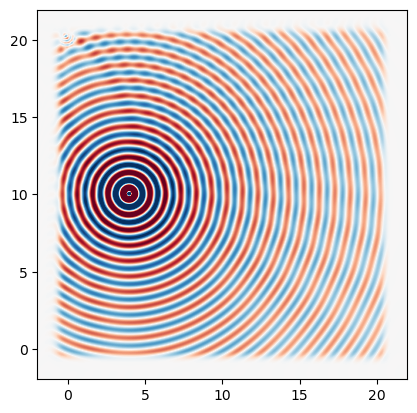

PyObject <matplotlib.image.AxesImage object at 0x7fa682677290>

In [17]:
Nx, Ny = length(x), length(y)
b = zeros(Nx,Ny)
b[Nx÷2, Ny÷4] = 1
@time u = reshape(A \ vec(b), Nx, Ny)
s = maximum(abs, real(u)) / 10
imshow(real(u), cmap="RdBu", vmin=-s, vmax=s,
       extent=(minimum(x),maximum(x),minimum(y),maximum(y)))

We solved a $200000\times200000$ matrix problem in **seconds**, and less than 1GB of memory.  Pretty good!

# Iterative solvers

Unfortunately, sparse-direct solvers like those we are using above have two limitations:

* They only work **if the matrix is sparse**.  There are lots of problems where $A$ has some special structure that lets you compute $A*x$ quickly, e.g. by FFTs, and avoid storing the whole matrix, but for which $A$ is not sparse.

* They **scale poorly** if the sparse matrix comes from a **3d grid or mesh**.  For an $s$-element 1d mesh with $n=s$ degrees of freedom, they have $O(s)$ complexity.  For an $s \times s$ 2d mesh with $n=s^2$ degrees of freedom, they take $O(n \log n)$ operations and require $O(n)$ storage.   But for a 3d $s\times s\times s$ mesh with $n = s^3$, they take $O(n^2)$ operations and require $O(n^{4/3})$ storage (and you often run out of storage before you run out of time).

The alternative is an **iterative solver**, in which you supply an initial guess for the solution $x$ (often just $x=0$) and then it *iteratively improves* the guess, converging (hopefully) to the solution $A^{-1} b$, while using *only* matrix-vector operations $Ax$.

Iterative solvers are the method of choice (or, more accurately, of necessity) for the very largest problems, but they have their downsides.  There are *many iterative solver algorithms*, and you have to know a little bit to pick the best one.  They *may not converge at all* for non-symmetric $A$, and in any case may *converge very slowly*, unless you provide a "magic" matrix called a *preconditioner* that is specific to your problem. (It is often a research problem in itself to find a good preconditioner!)

## Toy example: Steepest-descent algorithm

If $A$ is a **real-symmetric positive-definite** matrix, then solving $Ax = b$ is equivalent to minimizing the function:

$$
f(x) = x^T A x - x^T b - b^T x
$$

Just compute $\nabla f = \cdots = 2(Ax - b)$, which equals zero at the minimum.  The definiteness of $A$ means that the function $f$ is [convex](https://en.wikipedia.org/wiki/Convex_function), so there is exactly one global minimum.   Another way to see this: if $Az=b$, then $f(z+v) - f(z) = \cdots = v^T A v > 0$ for any vector $v \ne 0$, so $f(z)$ must be the minimum.

One of the simplest iterative algorithms is just to **go downhill**: minimize $f(x + \alpha d)$ over $\alpha$, where $d$ is the downhill direction $-\frac{1}{2}\nabla f = b - Ax = r$, where $r$ is called the *residual*.  We can perform this *line minimization* analytically for this $f$, for an arbitrary $d$, to find $\alpha = d^T r / d^T A d$.

The steepest-descent algorithm simply performs this downhill line-minimization repeatedly, starting at an initial guess `x` (typically just `x=0`), e.g. stopping when the norm of the residual is less than some tolerance times the norm of `b`.

In [18]:
function SD(A, b, x=zero(b); tol=1e-8, maxiters=1000)
    bnorm = norm(b)
    r = b - A*x # initial residual
    rnorm = [norm(r)] # return the array of residual norms
    Ad = zero(r) # allocate space for Ad
    for i = 1:maxiters
        d = r # use the steepest-descent direction
        mul!(Ad, A, d) # store matvec A*r in-place in Ar
        α = dot(d, r) / dot(d, Ad)
        x .= x .+ α .* d  # in Julia, this "fuses" into a single in-place update
        r .= r .- α .* Ad # update the residual (without computing A*x again)
        push!(rnorm, norm(r))
        rnorm[end] ≤ tol*bnorm && break # converged
    end
    return x, rnorm
end

SD (generic function with 2 methods)

In [19]:
A = rand(100,100); A = A'*A # a random SPD matrix
b = rand(100)
x, rnorm = SD(A, b, maxiters=1000)
length(rnorm), rnorm[end]/norm(b)

(1001, 0.34640165174003656)

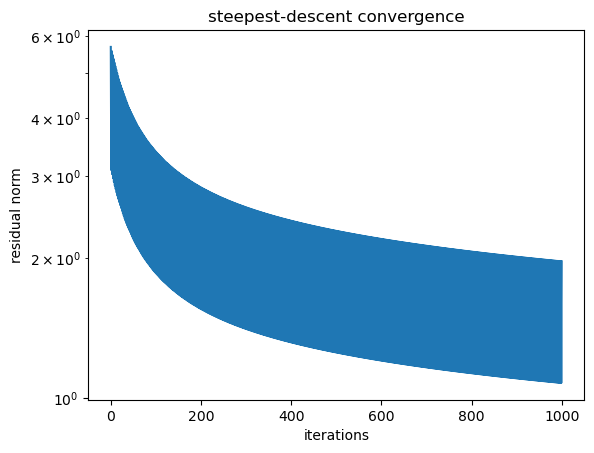

PyObject Text(0.5, 24.0, 'iterations')

In [20]:
semilogy(rnorm)
title("steepest-descent convergence")
ylabel("residual norm")
xlabel("iterations")

To see what's going on, let's try a $2\times2$ matrix where we can easily visualize the progress.

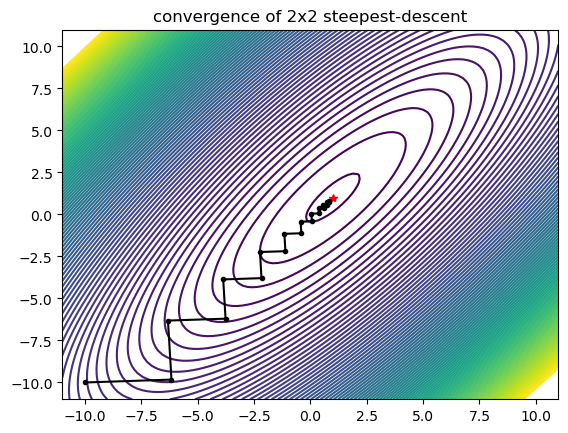

PyObject Text(0.5, 1.0, 'convergence of 2x2 steepest-descent')

In [21]:
θ = 0.9 # chosen to make a nice-looking plot
Q = [cos(θ) sin(θ); -sin(θ) cos(θ)] # 2x2 rotation by θ
A = Q * diagm([10,1]) * Q' # a 2x2 matrix with eigenvalues 10,1
b = A * [1,1] # right-hand side for solution (1,1)
x1 = range(-11,11,length=100)
contour(x1', x1, [dot([x1,x2], A*[x1,x2]) - 2*(x1*b[1]+x2*b[2]) for x1 in x1, x2 in x1], levels=range(1,2000,length=100))
plot(1,1, "r*")
x1s = Float64[]
x2s = Float64[]
for i = 0:20
    x, = SD(A, b, [-10.,-10.], maxiters=i)
    push!(x1s, x[1])
    push!(x2s, x[2])
end
plot(x2s, x1s, "k.-")

title("convergence of 2x2 steepest-descent")

The solution "zig-zags" down the long, narrow valley defined by the quadratic function `f`.  This is a common problem of steepest-descent algorithms: they tend to go towards the center of valleys (down the "steep" direction), rather than *along* the valleys towards the solution.

To fix this problem, basically we need to implement some kind of "memory": it has to "remember" that it just "zigged" in order to avoid "zagging" back where it came from.  

## From steepest-descent to conjugate-gradient

The most famous way to improve steepest descent with "memory" is the [conjugate-gradient algorithm](https://en.wikipedia.org/wiki/Conjugate_gradient_method).  I won't explain it here ([Shewchuk's article](http://www.cs.cmu.edu/~quake-papers/painless-conjugate-gradient.pdf) is a good introduction to its relationship to steepest descent), but the implementation ends up being *almost identical* to steepest descent.  However, instead of setting the line-search direction equal to the downhill direction `r`, the line-search direction is instead a linear combination of `r` with the *previous* search direction:

In [22]:
function CG(A, b, x=zero(b); tol=1e-8, maxiters=1000)
    bnorm = norm(b)
    r = b - A*x # initial residual
    rnorm = [norm(r)] # return the array of residual norms
    d = copy(r) # initial direction is just steepest-descent
    Ad = zero(r) # allocate space for Ad
    for i = 1:maxiters
        mul!(Ad, A, d) # store matvec A*r in-place in Ar
        α = dot(d, r) / dot(d, Ad)
        x .= x .+ α .* d  # in Julia 0.6, this "fuses" into a single in-place update
        r .= r .- α .* Ad # update the residual (without computing A*x again)
        push!(rnorm, norm(r))
        d .= r .+ d .* (rnorm[end]/rnorm[end-1])^2 # conjugate direction update
        rnorm[end] ≤ tol*bnorm && break # converged
    end
    return x, rnorm
end

CG (generic function with 2 methods)

In [23]:
A = rand(100,100); A = A'*A # a random SPD matrix
b = rand(100)
x, rnorm = CG(A, b)
length(rnorm), rnorm[end]/norm(b)

(197, 5.992446107091569e-9)

After some initial slow progress, the conjugate-gradient algorithm quickly zooms straight to the solution:

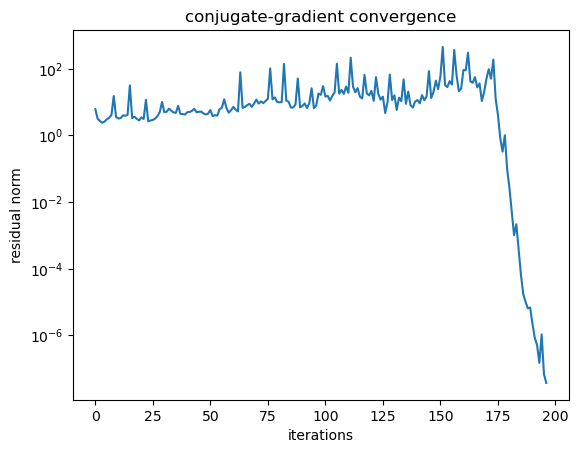

PyObject Text(0.5, 24.0, 'iterations')

In [24]:
semilogy(rnorm)
title("conjugate-gradient convergence")
ylabel("residual norm")
xlabel("iterations")

In our 2x2 problem, you can see that it actually converges in **two steps**:

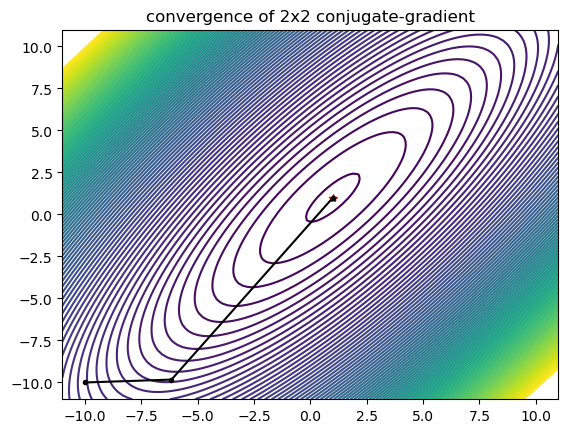

PyObject Text(0.5, 1.0, 'convergence of 2x2 conjugate-gradient')

In [25]:
θ = 0.9 # chosen to make a nice-looking plot
Q = [cos(θ) sin(θ); -sin(θ) cos(θ)] # 2x2 rotation by θ
A = Q * diagm([10,1]) * Q' # a 2x2 matrix with eigenvalues 10,1
b = A * [1,1] # right-hand side for solution (1,1)
x1 = range(-11,11,length=100)
contour(x1', x1, [dot([x1,x2], A*[x1,x2]) - 2*(x1*b[1]+x2*b[2]) for x1 in x1, x2 in x1], levels=range(1,2000,length=100))
plot(1,1, "r*")
x1s = Float64[]
x2s = Float64[]
for i = 0:2
    x, = CG(A, b, [-10.,-10.], maxiters=i)
    push!(x1s, x[1])
    push!(x2s, x[2])
end
plot(x2s, x1s, "k.-")

title("convergence of 2x2 conjugate-gradient")

## You don't have to write your own iterative solvers

There are several packages out there with iterative solvers that you can use, e.g. the [IterativeSolvers](https://github.com/JuliaMath/IterativeSolvers.jl) package or [KrylovKit](https://github.com/Jutho/KrylovKit.jl):

In [26]:
import IterativeSolvers

In [27]:
A = rand(100,100); A = A'*A # a random SPD matrix
b = rand(100)
x, ch = IterativeSolvers.cg(A, b, maxiter=300, log=true)
norm(A*x - b) / norm(b)

3.4563695505801597e-9

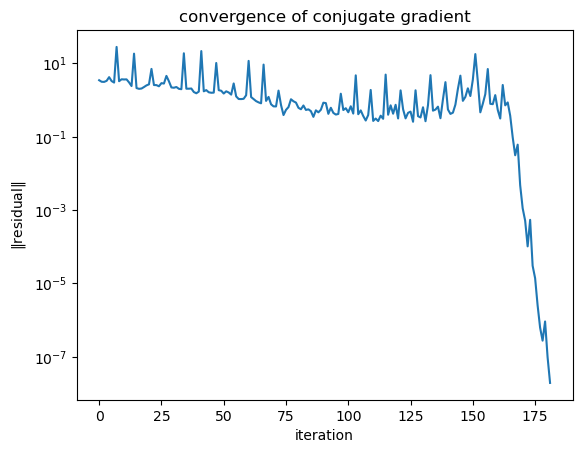

PyObject Text(0.5, 1.0, 'convergence of conjugate gradient')

In [28]:
semilogy(ch[:resnorm])
xlabel("iteration")
ylabel(L"\Vert \mathrm{residual} \Vert")
title("convergence of conjugate gradient")

## Preconditioners

Most iterative solvers are *greatly accelerated* if you can provide a *preconditioner* $P$: roughly, an *approximate inverse* of $A$ that is *easy to compute*.  The preconditioner is applied at *every step* of the iteration in order to speed up convergence.   (For example, you could solve $PAx = Pb$ instead of $Ax=b$; this is called a "left" preconditioner.)

For example, let's consider a problem where the matrix $A = L + S$ is a sum of the symmetric-tridiagonal discrete Laplacian $L$ (from above) and a *small, sparse* perturbation $S$.  As our preconditioner, we'll simply use $P = L^{-1}$, since this is a good approximation for $A$ and `L \ b` is fast (linear time):

In [29]:
n = 300
L = SymTridiagonal(fill(2.0,n), fill(-1.0, n-1))
b = rand(n)

S = sprand(n,n,0.001) * 0.1  # a small random, sparse perturbation
S = S'*S # needs to be symmetric positive-definite

A = sparse(L + S)

300×300 SparseMatrixCSC{Float64, Int64} with 924 stored entries:
⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡀⠀⢀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠐⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠐⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠁⠀⠀⠀⠀⠀⠀⠠⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠐⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠐⠀⠀⠀⠀⠀⠄⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠂⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡀⠀⠀
⠀⠀⠀⠀⠀⠀⠂⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠈⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡈⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠐⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠂⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠈⠀⠀⠄⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡀⠈⠻⣦⡀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠠⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠠⠀⠀⠀⠀⠀⠀⠀⠁⠀⠀⠀⠈⠻⣦⡀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠂⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦

Our home-brewed `CG` function above does not accept a preconditioner, but the IterativeSolvers package `cg` function does, and it makes a *huge* difference in the convergence:

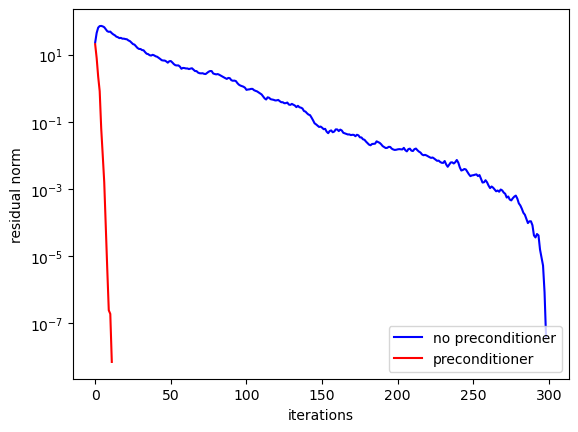

PyObject <matplotlib.legend.Legend object at 0x7fa694345f90>

In [30]:
x, ch = IterativeSolvers.cg(A, b, maxiter=300, log=true)
x′, ch′ = IterativeSolvers.cg(A, b, Pl=ldlt(L), maxiter=300, log=true)
semilogy(ch[:resnorm], "b-")
semilogy(ch′[:resnorm], "r-")
xlabel("iterations")
ylabel("residual norm")
legend(["no preconditioner", "preconditioner"], loc="lower right")

If you can find a good preconditioner, you can often speed things up by orders of magnitude.  Unfortunately, finding preconditioners is hard and problem-dependent.  There are some general "recipes" for things to try, but there are many problems (like the scalar-Helmholtz problem above) where good preconditioners are still an open research problem.

What makes a good preconditioner matrix $P$ for a matrix $A$?   For the "ideal" preconditioner $P = A^{-1}$, you would have $PA = I$, but of course this is impractical: if you could compute $A^{-1}$ quickly, you wouldn't need an iterative solver.   So, what you want is for $PA$ to be "like" $I$ in some sense.  The eigenvalues of $I$ are all 1, and it turns out that a good preconditioner makes $PA$ have eigenvalues that are mostly *clustered* together.

Let's see how the eigenvalues of $A$ and $PA = L^{-1} A$ compare in this case.

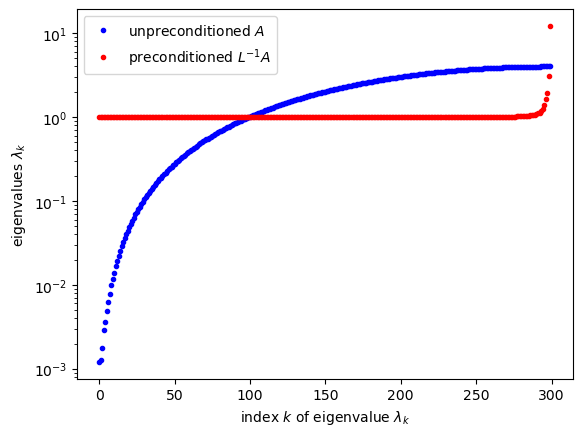

PyObject <matplotlib.legend.Legend object at 0x7fa647f11310>

In [31]:
semilogy(sort!(eigvals(Matrix(A))), "b.")
semilogy(sort!(eigvals(Matrix(A),Matrix(L))), "r.")
xlabel(L"index $k$ of eigenvalue $\lambda_k$")
ylabel(L"eigenvalues $\lambda_k$")
legend([L"unpreconditioned $A$", L"preconditioned $L^{-1} A$"])

You can see from the plot that $A$ has eigenvalues all over the map (from $10^{-3}$ to 10), but $L^{-1} A$ has eigenvalues that are mostly 1 (like $I$) with a handful of outliers.

# Key points

* Large matrix problems ($> 10^4 \times 10^4$) almost have a matrix $A$ with a **special structure** that allows you to **multiply Ax quickly**.  Most commonly, $A$ is **sparse** (mostly zero).

* Many specialized methods are available to **take advantage** of this special structure in order to solve problems **much faster than the n³ time and n² memory of "dense" solvers**.

  - For sparse matrices, `A \ b` can actually be solved *directly* by ordinary Gaussian elimination, cleverly re-ordering the unknowns so that the **LU factors remain sparse**.  These "sparse direct" methods are easy to use and widely available.
  
  - For the very largest matrices, for eigenproblems, or non-sparse matrices with a fast Ax, the alternative is an **iterative method**: start with guess for the solution, and do some clever operations that rapidly improve the guess *using only matrix-times-vector*.
  
  - In many problems, you can speed up iterative solvers by orders of magnitude if you have an *approximate* solution for Ax=b, even a *very "bad" approximation* that only uses *part* of th matrix.  Finding such **preconditioners** is often more of an art than a science.
  
* Fully understanding the methods for large sparse problems goes far beyond the scope of 18.06.  Better coverage is given in 18.335.  But **it is important to know that such methods are out there**, even if you don't understand the detail, so that you **know where to begin looking if you encounter a huge matrix in practice**.